<a href="https://colab.research.google.com/github/cduplan59/CFT_analysis/blob/main/Test_Gauss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Scan gaussien discriminant (ψ-test) ===
H_UV, H_IR = 30.0 4.0  |ΔH| = 26.0   H_base = 17.0
Fraction OK : 0.2573202614379085


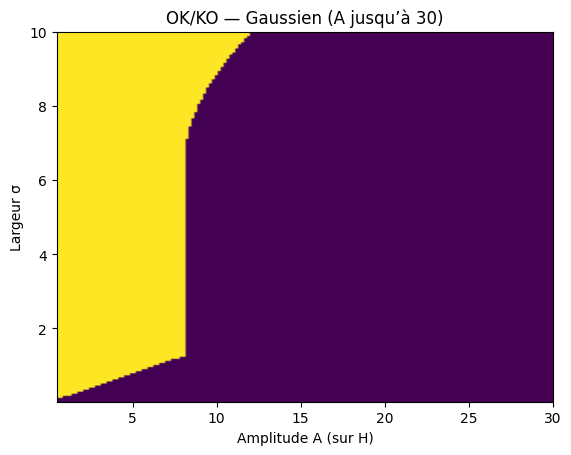


=== Frontières (quelques A) ===
 A  sigma_min  mpsi=max|ψ'|  mHrel=max|τ H'/H| active_constraint
 1   0.187263      0.249144           0.042372      eps_psi (ψ')
 2   0.354525      0.263203           0.083039      eps_psi (ψ')
 5   0.800559      0.291398           0.196181      eps_psi (ψ')
10   8.884916      0.052512           0.301417    eps_H (τ H'/H)
15        NaN           NaN                NaN             NO_OK
20        NaN           NaN                NaN             NO_OK
25        NaN           NaN                NaN             NO_OK
30        NaN           NaN                NaN             NO_OK


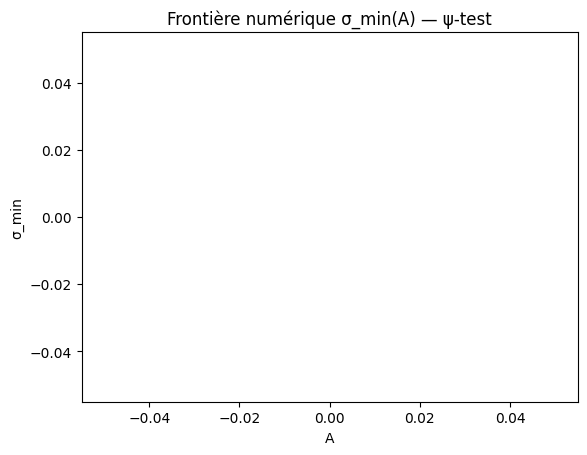


=== Diagnostics d’échec ===
Frac fail ψ'   : 0.23705882352941177
Frac fail Hrel : 0.7254248366013072
Frac fail both : 0.21980392156862746


In [ ]:
# Cellule Colab — TEST discriminant (ψ-test) avec amplitudes A ~ O(|ΔH|)
# Objectif : scanner A jusqu’à ~30 (comparable à |H_IR - H_UV|) et cartographier la zone OK/KO
# Conserve la définition Partie I : ψ(H) affine dans [-1,1] et contrainte sur max|ψ'| + max|τ H'/H|.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Réglages
# -----------------------------
eps_psi = 0.3
eps_H   = 0.3

tau_min, tau_max, N = -10.0, 10.0, 16000
tau = np.linspace(tau_min, tau_max, N)
tau0 = 0.0

H_UV = 30.0
H_IR = 4.0
dH = abs(H_IR - H_UV)

# Choix d’un niveau de base (à adapter à votre scénario)
# Ici, on place H_base au milieu pour éviter H<0 lors de bursts positifs.
H_base = 0.5*(H_UV + H_IR)  # ~17

# -----------------------------
# ψ(H) et burst gaussien sur H
# -----------------------------
def psi_of_H(H, H_IR=H_IR, H_UV=H_UV):
    return (2.0*H - (H_IR + H_UV)) / (H_IR - H_UV)

def H_gaussian(tau, H_base, A, sigma, tau0=tau0):
    X = A * np.exp(-0.5*((tau - tau0)/sigma)**2)
    return H_base + X

# -----------------------------
# Métriques
# -----------------------------
def metrics_from_H(H):
    dH_dtau = np.gradient(H, tau)
    psi = psi_of_H(H)
    dpsi = np.gradient(psi, tau)

    mpsi  = float(np.max(np.abs(dpsi)))
    mHrel = float(np.max(np.abs(tau * dH_dtau / H)))
    return mpsi, mHrel

def ok_both(mpsi, mHrel):
    return (mpsi <= eps_psi) and (mHrel <= eps_H)

def show_ok_map(ok, x_vals, y_vals, xlabel, ylabel, title):
    plt.figure()
    plt.imshow(ok, origin="lower", aspect="auto",
               extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# -----------------------------
# Scan discriminant : A ~ [0, 30] et sigma ~ [0.02, 10]
# -----------------------------
A_vals = np.linspace(0.5, 30.0, 170)
sigma_vals = np.linspace(0.02, 10.0, 180)

ok = np.zeros((len(sigma_vals), len(A_vals)), dtype=bool)
Mpsi = np.zeros_like(ok, dtype=float)
MHrel = np.zeros_like(ok, dtype=float)

# (Option) éviter H<=0 si A est négatif ; ici A>0 donc H>=H_base>0, OK.
for i, s in enumerate(sigma_vals):
    for j, A in enumerate(A_vals):
        H = H_gaussian(tau, H_base=H_base, A=A, sigma=s)
        mpsi, mHrel = metrics_from_H(H)
        Mpsi[i, j] = mpsi
        MHrel[i, j] = mHrel
        ok[i, j] = ok_both(mpsi, mHrel)

print("=== Scan gaussien discriminant (ψ-test) ===")
print("H_UV, H_IR =", H_UV, H_IR, " |ΔH| =", dH, "  H_base =", H_base)
print("Fraction OK :", float(ok.mean()))

show_ok_map(ok, A_vals, sigma_vals, "Amplitude A (sur H)", "Largeur σ", "OK/KO — Gaussien (A jusqu’à 30)")

# -----------------------------
# Frontière σ_min(A) et contrainte active
# -----------------------------
rows = []
A_probe = [1, 2, 5, 10, 15, 20, 25, 30]
for A0 in A_probe:
    j = int(np.argmin(np.abs(A_vals - A0)))
    ok_sig = sigma_vals[ok[:, j]]
    if len(ok_sig) == 0:
        rows.append([A0, np.nan, np.nan, np.nan, "NO_OK"])
        continue
    smin = float(ok_sig.min())

    H = H_gaussian(tau, H_base=H_base, A=A0, sigma=smin)
    mpsi, mHrel = metrics_from_H(H)
    rpsi = mpsi/eps_psi
    rH   = mHrel/eps_H
    active = "eps_psi (ψ')" if rpsi >= rH else "eps_H (τ H'/H)"
    rows.append([A0, smin, mpsi, mHrel, active])

df_front = pd.DataFrame(rows, columns=["A","sigma_min","mpsi=max|ψ'|","mHrel=max|τ H'/H|","active_constraint"])
print("\n=== Frontières (quelques A) ===")
print(df_front.to_string(index=False))

# -----------------------------
# Visualiser la "sévérité" : rapports aux seuils
# -----------------------------
plt.figure()
plt.plot(A_vals, (np.min(np.where(ok, sigma_vals[:,None], np.nan), axis=0)), label="σ_min(A) (grille)")
plt.xlabel("A"); plt.ylabel("σ_min")
plt.title("Frontière numérique σ_min(A) — ψ-test")
plt.show()

# Bonus : si vous voulez voir quelle contrainte domine globalement
# proportion de points qui échouent sur psi vs sur Hrel
fail_psi = (Mpsi > eps_psi)
fail_H   = (MHrel > eps_H)
print("\n=== Diagnostics d’échec ===")
print("Frac fail ψ'   :", float(fail_psi.mean()))
print("Frac fail Hrel :", float(fail_H.mean()))
print("Frac fail both :", float((fail_psi & fail_H).mean()))


=== Scan gaussien (ψ-test) : global vs fenêtre active ===
H_UV, H_IR = 30.0 3.0  |ΔH| = 27.0   H_base = 16.5
Fenêtre active : |τ-τ0| <= 5.0 * σ
Fraction OK (global) : 0.24830065359477124
Fraction OK (active) : 0.24830065359477124


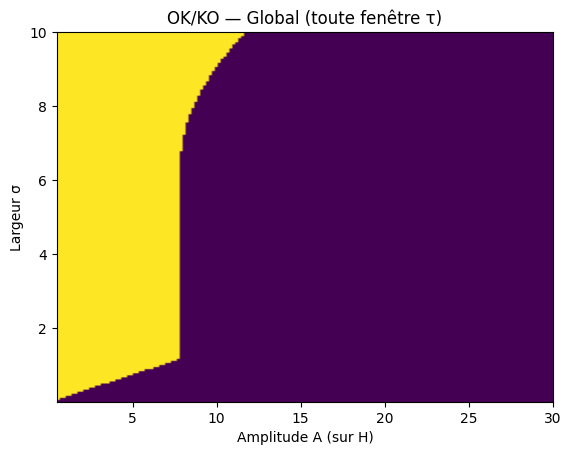

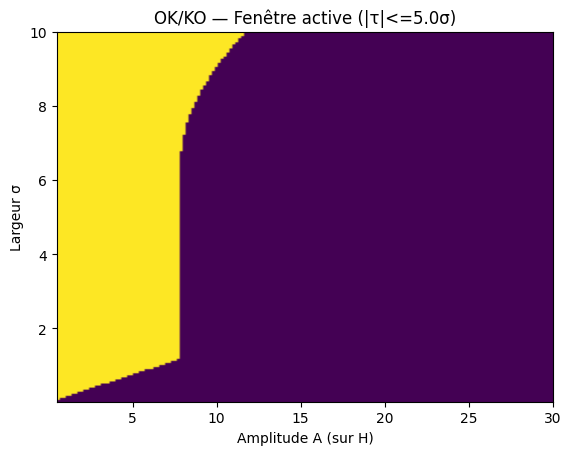


=== Frontières (GLOBAL) ===
 A  sigma_min  mpsi=max|ψ'|  mHrel=max|τ H'/H| active_constraint
 1   0.187263      0.239916           0.043629      eps_psi (ψ')
 2   0.354525      0.253455           0.085453      eps_psi (ψ')
 5   0.800559      0.280605           0.201581      eps_psi (ψ')
10   9.107933      0.049329           0.300267    eps_H (τ H'/H)
15        NaN           NaN                NaN             NO_OK
20        NaN           NaN                NaN             NO_OK
25        NaN           NaN                NaN             NO_OK
30        NaN           NaN                NaN             NO_OK

=== Frontières (ACTIVE-ONLY) ===
 A  sigma_min  mpsi=max|ψ'|  mHrel=max|τ H'/H| active_constraint
 1   0.187263      0.239916           0.043629      eps_psi (ψ')
 2   0.354525      0.253455           0.085453      eps_psi (ψ')
 5   0.800559      0.280605           0.201581      eps_psi (ψ')
10   9.107933      0.049329           0.300267    eps_H (τ H'/H)
15        NaN           NaN

In [ ]:
# Cellule Colab — Scan discriminant + contrôle "fenêtre active" (évite artefact des bords via |τ|)
# Idée : comparer les métriques sur tout τ et sur la zone active |τ-τ0| <= nwin * σ.
# Produit : carte OK/KO (global vs actif), frontières σ_min(A), et diagnostic contrainte active.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Réglages
# -----------------------------
eps_psi = 0.3
eps_H   = 0.3

tau_min, tau_max, N = -10.0, 10.0, 16000
tau = np.linspace(tau_min, tau_max, N)
tau0 = 0.0

H_UV = 30.0
H_IR = 3.0
dH = abs(H_IR - H_UV)

H_base = 0.5*(H_UV + H_IR)  # 16.5

nwin = 5.0   # fenêtre active : |τ-τ0| <= nwin*σ

# -----------------------------
# ψ(H) et burst
# -----------------------------
def psi_of_H(H, H_IR=H_IR, H_UV=H_UV):
    return (2.0*H - (H_IR + H_UV)) / (H_IR - H_UV)

def H_gaussian(tau, H_base, A, sigma, tau0=tau0):
    X = A * np.exp(-0.5*((tau - tau0)/sigma)**2)
    return H_base + X

# -----------------------------
# Métriques (global vs actif)
# -----------------------------
def metrics_from_H(H, sigma, active_only=False):
    dH_dtau = np.gradient(H, tau)
    psi = psi_of_H(H)
    dpsi = np.gradient(psi, tau)

    if active_only:
        mask = np.abs(tau - tau0) <= nwin * sigma
        # sécurité : si sigma est minuscule, le masque peut être trop petit
        if mask.sum() < 50:
            # élargit légèrement si besoin
            mask = np.abs(tau - tau0) <= max(nwin * sigma, 0.1)
    else:
        mask = slice(None)

    mpsi  = float(np.max(np.abs(dpsi[mask])))
    mHrel = float(np.max(np.abs((tau[mask]) * dH_dtau[mask] / H[mask])))

    return mpsi, mHrel

def ok_both(mpsi, mHrel):
    return (mpsi <= eps_psi) and (mHrel <= eps_H)

def show_ok_map(ok, x_vals, y_vals, xlabel, ylabel, title):
    plt.figure()
    plt.imshow(ok, origin="lower", aspect="auto",
               extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# -----------------------------
# Scan : A jusqu’à 30, sigma jusqu’à 10
# -----------------------------
A_vals = np.linspace(0.5, 30.0, 170)
sigma_vals = np.linspace(0.02, 10.0, 180)

ok_global = np.zeros((len(sigma_vals), len(A_vals)), dtype=bool)
ok_active = np.zeros_like(ok_global)

# Pour diagnostics d’échec
failpsi_global = np.zeros_like(ok_global)
failH_global   = np.zeros_like(ok_global)
failpsi_active = np.zeros_like(ok_global)
failH_active   = np.zeros_like(ok_global)

for i, s in enumerate(sigma_vals):
    for j, A in enumerate(A_vals):
        H = H_gaussian(tau, H_base=H_base, A=A, sigma=s)

        # global
        mpsi_g, mH_g = metrics_from_H(H, sigma=s, active_only=False)
        ok_global[i, j] = ok_both(mpsi_g, mH_g)
        failpsi_global[i, j] = (mpsi_g > eps_psi)
        failH_global[i, j]   = (mH_g > eps_H)

        # active-only
        mpsi_a, mH_a = metrics_from_H(H, sigma=s, active_only=True)
        ok_active[i, j] = ok_both(mpsi_a, mH_a)
        failpsi_active[i, j] = (mpsi_a > eps_psi)
        failH_active[i, j]   = (mH_a > eps_H)

print("=== Scan gaussien (ψ-test) : global vs fenêtre active ===")
print("H_UV, H_IR =", H_UV, H_IR, " |ΔH| =", dH, "  H_base =", H_base)
print("Fenêtre active : |τ-τ0| <=", nwin, "* σ")
print("Fraction OK (global) :", float(ok_global.mean()))
print("Fraction OK (active) :", float(ok_active.mean()))

show_ok_map(ok_global, A_vals, sigma_vals, "Amplitude A (sur H)", "Largeur σ", "OK/KO — Global (toute fenêtre τ)")
show_ok_map(ok_active, A_vals, sigma_vals, "Amplitude A (sur H)", "Largeur σ", f"OK/KO — Fenêtre active (|τ|<={nwin}σ)")

# -----------------------------
# Frontières σ_min(A) + contrainte active (global vs actif)
# -----------------------------
def frontier_table(ok_map, label):
    rows = []
    A_probe = [1, 2, 5, 10, 15, 20, 25, 30]
    for A0 in A_probe:
        j = int(np.argmin(np.abs(A_vals - A0)))
        ok_sig = sigma_vals[ok_map[:, j]]
        if len(ok_sig) == 0:
            rows.append([A0, np.nan, np.nan, np.nan, "NO_OK"])
            continue
        smin = float(ok_sig.min())
        H = H_gaussian(tau, H_base=H_base, A=A0, sigma=smin)
        mpsi, mHrel = metrics_from_H(H, sigma=smin, active_only=(label=="active"))
        rpsi = mpsi/eps_psi
        rH   = mHrel/eps_H
        active = "eps_psi (ψ')" if rpsi >= rH else "eps_H (τ H'/H)"
        rows.append([A0, smin, mpsi, mHrel, active])

    df = pd.DataFrame(rows, columns=["A","sigma_min","mpsi=max|ψ'|","mHrel=max|τ H'/H|","active_constraint"])
    return df

df_front_global = frontier_table(ok_global, label="global")
df_front_active = frontier_table(ok_active, label="active")

print("\n=== Frontières (GLOBAL) ===")
print(df_front_global.to_string(index=False))

print("\n=== Frontières (ACTIVE-ONLY) ===")
print(df_front_active.to_string(index=False))

# -----------------------------
# Diagnostics d’échec : qui tue quoi ?
# -----------------------------
print("\n=== Diagnostics d’échec (GLOBAL) ===")
print("Frac fail ψ'   :", float(failpsi_global.mean()))
print("Frac fail Hrel :", float(failH_global.mean()))
print("Frac fail both :", float((failpsi_global & failH_global).mean()))

print("\n=== Diagnostics d’échec (ACTIVE-ONLY) ===")
print("Frac fail ψ'   :", float(failpsi_active.mean()))
print("Frac fail Hrel :", float(failH_active.mean()))
print("Frac fail both :", float((failpsi_active & failH_active).mean()))
